In [1]:
import torch
from torch import nn
from d2l import torch as d2l

#VGG块
def vgg_block(num_convs, in_channels, out_channels):#块中卷积层数，输入输出通道数
    layers = []
    for _ in range(num_convs):#用for循环
        layers.append(nn.Conv2d(
            in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels#添加一层后取当前输出通道数为下一层输入通道数，
        #这里说明VGG块改变通道数的方法是在第一层就将通道数改变好，后面层中通道数全不变
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [2]:
#每个VGG块的（卷积层数，输出通道数）
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

#VGG网络
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1#初始输入图像为单通道
    for (num_convs, out_channels) in conv_arch:#依次读取VGG块尺寸并创建
        conv_blks.append(vgg_block(
            num_convs, in_channels, out_channels))
        in_channels = out_channels#输入通道数随每层输出通道数更新
        
    return nn.Sequential(
        *conv_blks, nn.Flatten(),#“*”将列表中所有元素解开成独立的参数
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(),
        nn.Dropout(0.5), nn.Linear(4096, 4096), nn.ReLU(),
        nn.Dropout(0.5), nn.Linear(4096, 10))

net = vgg(conv_arch)

In [3]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'ouput shape:\t', X.shape)
    
#总体而言，网络分为五块，每一块将输入宽高减半，通道数翻倍

Sequential ouput shape:	 torch.Size([1, 64, 112, 112])
Sequential ouput shape:	 torch.Size([1, 128, 56, 56])
Sequential ouput shape:	 torch.Size([1, 256, 28, 28])
Sequential ouput shape:	 torch.Size([1, 512, 14, 14])
Sequential ouput shape:	 torch.Size([1, 512, 7, 7])
Flatten ouput shape:	 torch.Size([1, 25088])
Linear ouput shape:	 torch.Size([1, 4096])
ReLU ouput shape:	 torch.Size([1, 4096])
Dropout ouput shape:	 torch.Size([1, 4096])
Linear ouput shape:	 torch.Size([1, 4096])
ReLU ouput shape:	 torch.Size([1, 4096])
Dropout ouput shape:	 torch.Size([1, 4096])
Linear ouput shape:	 torch.Size([1, 10])


In [4]:
#VGG-11计算量太大，这里构建了一个四分之一尺寸的网络来训练,计算量为1/16,但依然很大

ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

training on cpu


ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

RuntimeError: DataLoader worker (pid 59863) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.

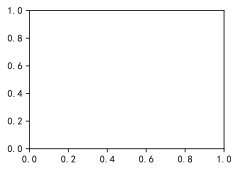

In [7]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())